# Apresentação

Este trabalho tem como proposta a utilização de arquiteturas CNN para a resolução de problemas de classificação de imagens.

## Dataset
Escolhemos o dataset [**Sentinel-2 Land Cover Dataset**](https://www.kaggle.com/datasets/salmaadell/eurosat-rgb/data) para a tarefa de classificação multiclasse.


In [ ]:
import tqdm
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

import warnings
warnings.filterwarnings("ignore")

import torchvision
from torchsummary import summary
import torchvision.transforms.v2 as transforms
from torchvision import datasets

import os

In [26]:
class cnn(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        
        # Input: 3 channels x 64x64
        # Feature map sequence: 3 → 16 → 32 channels
        # Why double channel numbers at each Conv Block?
        # Progressive feature learning
        # Conv Block 1 learns basic patterns
        # Conv Block 2 learns more complex patterns
        self.features = nn.Sequential(
            # Conv Block 1 (64x64 -> 32x32)
            # in_channels, out_channels, kernel_size, stride=1
            nn.Conv2d(3, 16, 3, padding=1),  # Preserve spatial dimensions
            nn.BatchNorm2d(16),               # stabilise training
            nn.ReLU(),                        # relu activation - avoid vanishing gradients
            # kernel_size=2
            # Why perform pooling - decrease spatial dimensions/computations, increase 'receptive field'
            nn.MaxPool2d(2),
            # output from Conv Block 1: 16 channels x 32x32


            # Conv Block 2 (32x32 -> 16x16)
            nn.Conv2d(16, 32, 3, padding=1),
            # From Conv2d: 32 channels x 32x32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # Output from Conv Block 2: 16x16x32

            
            # Additional pooling to reduce dimensions further
            # New layer to standardise output size
            nn.AdaptiveAvgPool2d((16, 16))
        )
        

        self.classifier = nn.Sequential(
            nn.Flatten(),                     # Prepare for FC layers
            nn.Linear(32*16*16, 256),         # Reduced feature dimension
            nn.Dropout(0.5),                  # Regularization
            nn.Linear(256, 10),
            # nn.Sigmoid()                      # Binary classification output
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

# Train Classifier

In [ ]:
class Trainer:
    """
    Class to train and evaluate a PyTorch model with early stopping and metric tracking.
    """
    def __init__(self, model, dataloader={"train": [], "val": [], "test": []}, epochs=20, criterion=None, optimizer=None, learning_rate=1e-5, device=None, patience=3, class_names=[], best_model_path="./best_model", best_model_filename="best_model.pth"):
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
        print(f"Using device: {self.device}")
        
        self.model = model
        self.model.to(self.device)
        
        # Dataloaders
        self.dataloader = dataloader

        sample_batch = next(iter(self.dataloader["train"]))
        sample_labels = sample_batch[1]
        
        self.unique_labels = torch.unique(sample_labels)
        self.num_classes = len(self.unique_labels)
        self.class_names = class_names

        if self.num_classes == 2:
            self.criterion = torch.nn.BCEWithLogitsLoss() if criterion is None else criterion
        else:
            self.criterion = torch.nn.CrossEntropyLoss() if criterion is None else criterion

        print(f"Number of classes: {self.num_classes}")
        print(f"Using loss function: {self.criterion.__class__.__name__}")
        
        self.learning_rate = learning_rate
        self.optimizer = optimizer if optimizer else torch.optim.AdamW(self.model.parameters(), 
                                                                    lr=self.learning_rate, 
                                                                    weight_decay=1e-2)
        # Early stopping
        self.patience = patience
        
        # Histórico de métricas
        self.history = {
            "train_loss": [], "val_loss": [],
            "train_acc": [], "val_acc": [],
            "train_f1": [], "val_f1": [],
            "train_precision": [], "val_precision": [],
            "train_recall": [], "val_recall": []
        }
        self.best_val_loss = float('inf')
        self.early_stop_counter = 0

        self.epochs = epochs
        self.best_model_path = best_model_path
        self.best_model_filename = best_model_filename


    def check_early_stopping(self, val_loss):
        eps = 0.01 # 1% val loss improvement required
        improvement = 0.0
        
        # First epoch
        if self.best_val_loss == float('inf'):
            best_loss = val_loss
            improvement = 1.0  # 100% improvement from infinity
        # subsequent epochs
        else:
            improvement = (self.best_val_loss - val_loss) / self.best_val_loss
            
        # Check if validation loss improved
        if improvement > eps:
            print(f"Validation loss improved from {self.best_val_loss:.4f} to {val_loss:.4f}.")
            # Save the best model
            self.best_val_loss = val_loss
            self.early_stop_counter = 0
            self.save_best_model()
        else:
            print(f"Validation loss did not improve from {self.best_val_loss:.4f} to {val_loss:.4f}.")
            # Increment early stop counter
            self.early_stop_counter += 1
            print(f"Early stop counter: {self.early_stop_counter}/{self.patience}")
            if self.early_stop_counter >= self.patience:
                return True
        return False


    def save_best_model(self):
        os.makedirs(self.best_model_path, exist_ok=True)
        model_path = os.path.join(self.best_model_path, self.best_model_filename)
        torch.save(self.model.state_dict(), model_path)
        print(f"Best model saved to {model_path}")


    def fit(self):
        for epoch in range(self.epochs):
            _ = self.train_epoch(epoch)
            history = self.evaluate()

            if self.check_early_stopping(history['loss']):
                print(f"Early stopping triggered at epoch {epoch + 1}.")
                break


    def train_epoch(self, epoch, train=True, testing=False):
        """
        Train the model for one epoch.
        """
        
        phase = "train" if train else "val" if not testing else "test"

        if train:
            self.model.train()
        else:
            self.model.eval()
            
        losses = []
        all_predictions = []
        all_labels = []
        
        bar = tqdm.tqdm(self.dataloader[phase], desc=f"{phase.capitalize()} Epoch {epoch+1 }/{self.epochs}", unit="batch")
        for index, pack in enumerate(bar):
            # Unpack the batch
            x, labels = pack
            x = x.to(self.device)
            labels = labels.to(self.device)
            
            # Convert labels to float and set to 1.0 (all samples are positive class)
            if self.num_classes == 2:
                labels = labels.float()
                labels = torch.ones_like(labels)
            else:
                labels = labels.squeeze()
            self.optimizer.zero_grad()
            
            # Forward pass
            # Use torch.set_grad_enabled to enable/disable gradient calculation
            with torch.set_grad_enabled(train):
                logits = self.model(x).squeeze(1)
                if self.num_classes == 2:
                    # Binary classification
                    labels = labels.float()
                    loss = self.criterion(logits, labels)
                    prediction = torch.sigmoid(logits).detach().cpu().numpy().round()
                else:
                    # Multi-class classification
                    labels = labels.squeeze()
                    loss = self.criterion(logits, labels)
                    prediction = torch.argmax(logits, 1).detach().cpu().numpy()
                
            # Backward pass and optimization
            if phase == 'train':
                loss.backward()
                self.optimizer.step()

            # Store predictions
            losses.append(loss.item())
        
            true_labels = labels.cpu().numpy()
        
            # Save predictions and labels
            all_predictions.extend(prediction)
            all_labels.extend(true_labels)
            if index % 10 == 0:
                bar.set_postfix(loss=np.mean(losses))

        history = self.compute_metrics(all_predictions, all_labels)
        history['loss'] = np.mean(losses)
        
        # Save metrics to history
        if train:
            self.update_history(history, train=True)
            print(f"Epoch {epoch+1} - Train Loss: {np.mean(losses):.4f} - Train Accuracy: {history['accuracy']:.4f} - Train F1: {history['f1']:.4f} - Train Precision: {history['precision']:.4f} - Train Recall: {history['recall']:.4f}")
        elif not testing:
            # Validation
            self.update_history(history, train=False)
            print(f"Epoch {epoch+1} - Val Loss: {np.mean(losses):.4f} - Val Accuracy: {history['accuracy']:.4f} - Val F1: {history['f1']:.4f} - Val Precision: {history['precision']:.4f} - Val Recall: {history['recall']:.4f}")
        return history
    

    def test(self):
        """
        Evaluate the model on the test set.
        """
        return self.train_epoch(0, train=False, testing=True)


    def evaluate(self, testing=False):
        """
        Evaluate the model on the validation set.
        """
        return self.train_epoch(0, train=False, testing=testing)


    def predict(self, x):
        """
        Predict the class of the input data.
        """
        self.model.eval()
        x = x.to(self.device)
        
        with torch.no_grad():
            logits = self.model(x).squeeze(1)
            if self.num_classes == 2:
                prediction = torch.sigmoid(logits).detach().cpu().numpy().round()
            else:
                prediction = torch.argmax(logits, 1).detach().cpu().numpy()
        
        return prediction


    def update_history(self, history, train=True):
        prefix = "train" if train else "val"
        self.history[f"{prefix}_loss"].append(history['loss'])
        self.history[f"{prefix}_acc"].append(history['accuracy'])
        self.history[f"{prefix}_precision"].append(history['precision'])
        self.history[f"{prefix}_recall"].append(history['recall'])
        self.history[f"{prefix}_f1"].append(history['f1'])


    def compute_metrics(self, predictions, labels):
        predictions = np.array(predictions)
        labels = np.array(labels)
        
        average = 'binary' if self.num_classes == 2 else 'weighted'
        return {
            "accuracy": accuracy_score(labels, predictions),
            "f1": f1_score(labels, predictions, average=average, zero_division=0),
            "precision": precision_score(labels, predictions, average=average, zero_division=0),
            "recall": recall_score(labels, predictions, average=average, zero_division=0),
            "confusion_matrix": confusion_matrix(labels, predictions)
        }
        

    def plot_metrics(self, history=None):
        if not history:
            history = self.history
        epochs = range(1, len(history['train_loss']) + 1)
        
        plt.figure(figsize=(20, 8))
        
        # Plotting Loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, history['train_loss'], 'b', label='Train Loss')
        plt.plot(epochs, history['val_loss'], 'r', label='Validation Loss')
        plt.title('Train and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        # Plotting all other metrics
        plt.subplot(1, 2, 2)
        plt.plot(epochs, history['train_acc'], 'b-', label='Train Accuracy')
        plt.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy')
        plt.plot(epochs, history['train_precision'], 'b--', label='Train Precision')
        plt.plot(epochs, history['val_precision'], 'r--', label='Validation Precision')
        plt.plot(epochs, history['train_recall'], 'b-.', label='Train Recall')
        plt.plot(epochs, history['val_recall'], 'r-.', label='Validation Recall')
        plt.plot(epochs, history['train_f1'], 'b:', label=
                 'Train F1')
        plt.plot(epochs, history['val_f1'], 'r:', label='Validation F1')
        plt.title('Train and Validation Metrics')
        plt.xlabel('Epochs')
        plt.ylabel('Score')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        plt.tight_layout()
        plt.show()
        
    def plot_confusion_matrix(self, cm=None, class_names=None):
        """
        Plot the confusion matrix.
        """
        if cm is None:
            cm = self.history['confusion_matrix']
        if class_names is None:
            class_names = self.class_names
            
        # Normalize the confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=class_names, yticklabels=class_names)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()

# Prepare Dataset

In [68]:
n_annualcrop = 0
n_highway = 0
dataset_path = '/kaggle/input/eurosat-rgb/EuroSAT_RGB' if not os.path.exists('./EuroSAT_RGB') else './EuroSAT_RGB'
for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        if 'annualcrop' in filename.lower():
            n_annualcrop += 1
        elif 'highway' in filename.lower():
            n_highway += 1

print(f"n_annualcrop: {n_annualcrop}, n_highway: {n_highway}")

n_annualcrop: 3000, n_highway: 2500


In [69]:
# Define transformations that resize the images to 256x256, and normalize them.
# The means and standard deviations of each channel are the values used for normalization in ImageNet
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

# to simplify our analysis to focus on transfer learning, we will not do additional transformations for the validation set
data_transforms = {
    'all': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ])
}

In [70]:
# Create combined dataset with proper class structure
dataset = datasets.ImageFolder(
    root='./EuroSAT_RGB',
    transform=data_transforms['all']
)
dataset

Dataset ImageFolder
    Number of datapoints: 27000
    Root location: ./EuroSAT_RGB
    StandardTransform
Transform: Compose(
                 Resize(size=[256, 256], interpolation=InterpolationMode.BILINEAR, antialias=True)
                 ToTensor()
                 Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
           )

In [60]:
dataset.class_to_idx

{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}

In [61]:
def create_class_subset(dataset, class_name):
    class_idx = dataset.class_to_idx[class_name]
    indices = [i for i, (_, label) in enumerate(dataset.samples) if label == class_idx]
    return Subset(dataset, indices)

In [62]:
# Split the dataset into train, validation, and test sets
class_names = dataset.classes
print(f"Classes: {class_names}")
# Create subsets for each class

combined_dataset = {"train": [], "val": [], "test": []}
for class_name in class_names:
    # Create a subset for the class
    class_subset = create_class_subset(dataset, class_name)
    
    # Split the subset into train, validation, and test sets
    train_size = int(0.7 * len(class_subset))
    val_size = int(0.15 * len(class_subset))
    test_size = len(class_subset) - train_size - val_size
    train_subset, val_subset, test_subset = random_split(class_subset, [train_size, val_size, test_size])
    
    # Append the subsets to the combined dataset
    combined_dataset["train"].append(train_subset)
    combined_dataset["val"].append(val_subset)
    combined_dataset["test"].append(test_subset)

final_dataset = {
    "train": [],
    "val": [],
    "test": []
}

# Concatenate the subsets for each phase
final_dataset["train"] = torch.utils.data.ConcatDataset(combined_dataset["train"])
final_dataset["val"] = torch.utils.data.ConcatDataset(combined_dataset["val"])
final_dataset["test"] = torch.utils.data.ConcatDataset(combined_dataset["test"])

# Print the sizes of the final datasets
print(f"Train dataset size: {len(final_dataset['train'])}")
print(f"Validation dataset size: {len(final_dataset['val'])}")
print(f"Test dataset size: {len(final_dataset['test'])}")

data_loaders = {
    "train": DataLoader(final_dataset["train"], batch_size=24, shuffle=True),
    "val": DataLoader(final_dataset["val"], batch_size=64, shuffle=False),
    "test": DataLoader(final_dataset["test"], batch_size=64, shuffle=False)
}

Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Train dataset size: 18900
Validation dataset size: 4050
Test dataset size: 4050


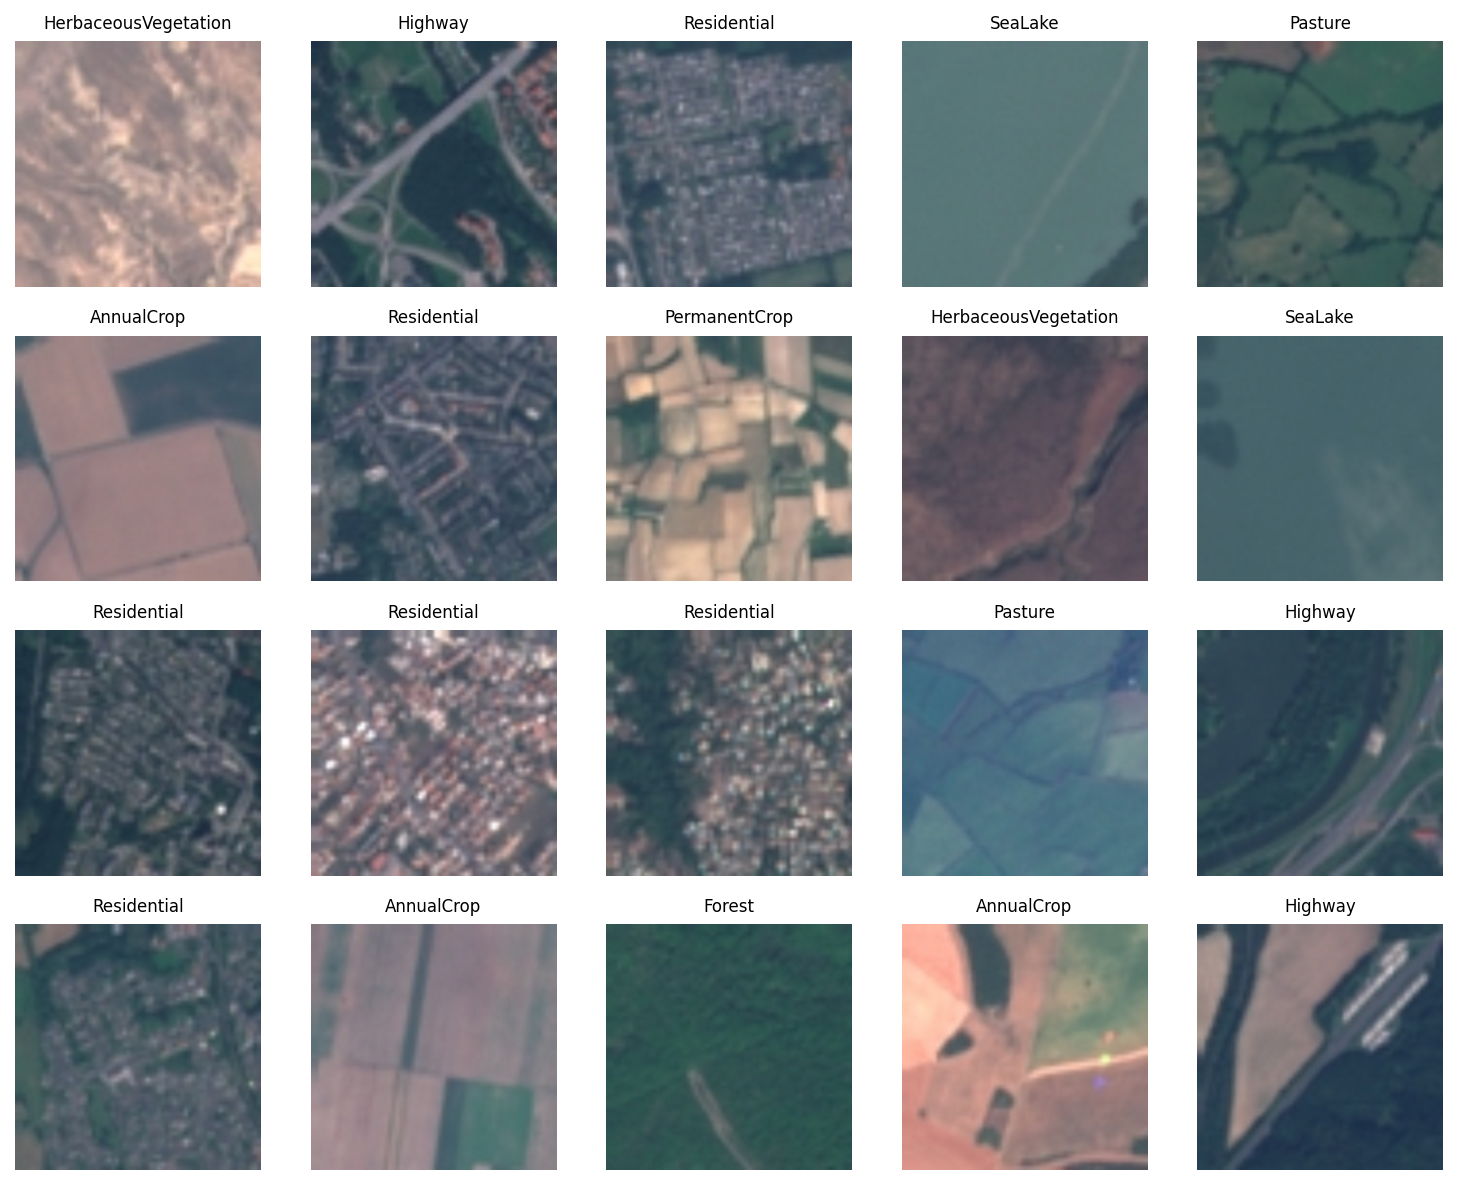

In [63]:
# Helper function to show a 4x5 grid of images with labels from a batch
def show_batch_grid(inputs, classes, class_names, means, stds, nrow=4, ncol=5):
    fig, axes = plt.subplots(nrow, ncol, figsize=(ncol*2, nrow*2), dpi=150)
    for i in range(nrow * ncol):
        if i >= inputs.size(0):
            axes.flat[i].axis('off')
            continue
        img = inputs[i].cpu().numpy().transpose((1, 2, 0))
        img = stds * img + means
        img = np.clip(img, 0, 1)
        axes.flat[i].imshow(img)
        axes.flat[i].set_title(class_names[classes[i]], fontsize=8)
        axes.flat[i].axis('off')
    plt.tight_layout()
    plt.show()

# Show a 4x5 grid from the sample batch
# Get a batch from the train dataloader

# Only show a batch, do not create a new iterator that could affect training order
batch = next(iter(data_loaders['train']))
inputs, classes = batch
show_batch_grid(inputs, classes, class_names, np.array(means), np.array(stds), nrow=4, ncol=5)


In [64]:
# check if the dataloaders are working
for phase in data_loaders:
    print(f"Phase: {phase}")
    for images, labels in data_loaders[phase]:
        print(f"Batch size: {images.size()}, Labels: {labels.size()}")
        print(f"Labels: {labels}")
        # Check if the labels are correct
        if phase == "train":
            for label in labels:
                if label.item() < 0 or label.item() > 9:
                    print(f"Unexpected label: {label.item()}")
        else:
            for label in labels:
                if label.item() < 0 or label.item() > 9:
                    print(f"Unexpected label: {label.item()}")
        # Check if the images are correct
        if images.size(1) != 3 or images.size(2) != 256 or images.size(3) != 256:
            print(f"Unexpected image size: {images.size()}")
        else:
            print(f"Image size: {images.size()}")
        break
    break
# Check if the model is working
model = cnn()
model.to("cpu")
summary(model, (3, 256, 256), device="cpu")

Phase: train
Batch size: torch.Size([24, 3, 256, 256]), Labels: torch.Size([24])
Labels: tensor([9, 9, 7, 6, 0, 9, 5, 8, 1, 8, 3, 2, 7, 1, 3, 0, 7, 5, 1, 8, 9, 6, 5, 7])
Image size: torch.Size([24, 3, 256, 256])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             448
       BatchNorm2d-2         [-1, 16, 256, 256]              32
              ReLU-3         [-1, 16, 256, 256]               0
         MaxPool2d-4         [-1, 16, 128, 128]               0
            Conv2d-5         [-1, 32, 128, 128]           4,640
       BatchNorm2d-6         [-1, 32, 128, 128]              64
              ReLU-7         [-1, 32, 128, 128]               0
         MaxPool2d-8           [-1, 32, 64, 64]               0
 AdaptiveAvgPool2d-9           [-1, 32, 16, 16]               0
          Flatten-10                 [-1, 8192]               0
           Linear-1

Using device: mps
Number of classes: 8
Using loss function: CrossEntropyLoss


Train Epoch 1/40: 100%|██████████| 788/788 [00:45<00:00, 17.41batch/s, loss=1.31]


Epoch 1 - Train Loss: 1.3055 - Train Accuracy: 0.5537 - Train F1: 0.5469 - Train Precision: 0.5449 - Train Recall: 0.5537


Val Epoch 1/40: 100%|██████████| 64/64 [00:05<00:00, 10.81batch/s, loss=0.92] 


Epoch 1 - Val Loss: 0.9101 - Val Accuracy: 0.6807 - Val F1: 0.6638 - Val Precision: 0.7016 - Val Recall: 0.6807
Validation loss improved from inf to 0.9101.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model.pth


Train Epoch 2/40: 100%|██████████| 788/788 [00:42<00:00, 18.38batch/s, loss=1]   


Epoch 2 - Train Loss: 1.0045 - Train Accuracy: 0.6566 - Train F1: 0.6531 - Train Precision: 0.6522 - Train Recall: 0.6566


Val Epoch 1/40: 100%|██████████| 64/64 [00:05<00:00, 10.94batch/s, loss=0.902]


Epoch 1 - Val Loss: 0.9088 - Val Accuracy: 0.6869 - Val F1: 0.6866 - Val Precision: 0.7205 - Val Recall: 0.6869
Validation loss did not improve from 0.9101 to 0.9088.
Early stop counter: 1/3


Train Epoch 3/40: 100%|██████████| 788/788 [00:41<00:00, 18.88batch/s, loss=0.897]


Epoch 3 - Train Loss: 0.8961 - Train Accuracy: 0.6919 - Train F1: 0.6894 - Train Precision: 0.6888 - Train Recall: 0.6919


Val Epoch 1/40: 100%|██████████| 64/64 [00:05<00:00, 11.09batch/s, loss=0.757]


Epoch 1 - Val Loss: 0.7364 - Val Accuracy: 0.7398 - Val F1: 0.7373 - Val Precision: 0.7487 - Val Recall: 0.7398
Validation loss improved from 0.9101 to 0.7364.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model.pth


Train Epoch 4/40: 100%|██████████| 788/788 [00:44<00:00, 17.69batch/s, loss=0.822]


Epoch 4 - Train Loss: 0.8229 - Train Accuracy: 0.7183 - Train F1: 0.7166 - Train Precision: 0.7164 - Train Recall: 0.7183


Val Epoch 1/40: 100%|██████████| 64/64 [00:05<00:00, 10.76batch/s, loss=0.811]


Epoch 1 - Val Loss: 0.7875 - Val Accuracy: 0.7220 - Val F1: 0.7152 - Val Precision: 0.7433 - Val Recall: 0.7220
Validation loss did not improve from 0.7364 to 0.7875.
Early stop counter: 1/3


Train Epoch 5/40: 100%|██████████| 788/788 [00:43<00:00, 18.01batch/s, loss=0.758]


Epoch 5 - Train Loss: 0.7578 - Train Accuracy: 0.7413 - Train F1: 0.7396 - Train Precision: 0.7392 - Train Recall: 0.7413


Val Epoch 1/40: 100%|██████████| 64/64 [00:05<00:00, 11.55batch/s, loss=0.748]


Epoch 1 - Val Loss: 0.7191 - Val Accuracy: 0.7333 - Val F1: 0.7272 - Val Precision: 0.7488 - Val Recall: 0.7333
Validation loss improved from 0.7364 to 0.7191.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model.pth


Train Epoch 6/40: 100%|██████████| 788/788 [00:42<00:00, 18.54batch/s, loss=0.722]


Epoch 6 - Train Loss: 0.7207 - Train Accuracy: 0.7514 - Train F1: 0.7498 - Train Precision: 0.7492 - Train Recall: 0.7514


Val Epoch 1/40: 100%|██████████| 64/64 [00:05<00:00, 11.22batch/s, loss=0.698]


Epoch 1 - Val Loss: 0.6738 - Val Accuracy: 0.7570 - Val F1: 0.7480 - Val Precision: 0.7623 - Val Recall: 0.7570
Validation loss improved from 0.7191 to 0.6738.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model.pth


Train Epoch 7/40: 100%|██████████| 788/788 [00:44<00:00, 17.82batch/s, loss=0.672]


Epoch 7 - Train Loss: 0.6720 - Train Accuracy: 0.7683 - Train F1: 0.7666 - Train Precision: 0.7662 - Train Recall: 0.7683


Val Epoch 1/40: 100%|██████████| 64/64 [00:05<00:00, 11.26batch/s, loss=0.691]


Epoch 1 - Val Loss: 0.7105 - Val Accuracy: 0.7521 - Val F1: 0.7472 - Val Precision: 0.7648 - Val Recall: 0.7521
Validation loss did not improve from 0.6738 to 0.7105.
Early stop counter: 1/3


Train Epoch 8/40: 100%|██████████| 788/788 [00:43<00:00, 18.26batch/s, loss=0.644]


Epoch 8 - Train Loss: 0.6445 - Train Accuracy: 0.7789 - Train F1: 0.7776 - Train Precision: 0.7773 - Train Recall: 0.7789


Val Epoch 1/40: 100%|██████████| 64/64 [00:05<00:00, 12.22batch/s, loss=0.634]


Epoch 1 - Val Loss: 0.6226 - Val Accuracy: 0.7805 - Val F1: 0.7800 - Val Precision: 0.7865 - Val Recall: 0.7805
Validation loss improved from 0.6738 to 0.6226.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model.pth


Train Epoch 9/40: 100%|██████████| 788/788 [00:43<00:00, 17.98batch/s, loss=0.618]


Epoch 9 - Train Loss: 0.6187 - Train Accuracy: 0.7854 - Train F1: 0.7843 - Train Precision: 0.7839 - Train Recall: 0.7854


Val Epoch 1/40: 100%|██████████| 64/64 [00:05<00:00, 10.74batch/s, loss=0.62] 


Epoch 1 - Val Loss: 0.6039 - Val Accuracy: 0.7842 - Val F1: 0.7802 - Val Precision: 0.7809 - Val Recall: 0.7842
Validation loss improved from 0.6226 to 0.6039.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model.pth


Train Epoch 10/40: 100%|██████████| 788/788 [00:43<00:00, 18.29batch/s, loss=0.591]


Epoch 10 - Train Loss: 0.5905 - Train Accuracy: 0.7971 - Train F1: 0.7961 - Train Precision: 0.7958 - Train Recall: 0.7971


Val Epoch 1/40: 100%|██████████| 64/64 [00:05<00:00, 10.93batch/s, loss=0.607]


Epoch 1 - Val Loss: 0.6002 - Val Accuracy: 0.7891 - Val F1: 0.7885 - Val Precision: 0.7942 - Val Recall: 0.7891
Validation loss did not improve from 0.6039 to 0.6002.
Early stop counter: 1/3


Train Epoch 11/40: 100%|██████████| 788/788 [00:40<00:00, 19.39batch/s, loss=0.565]


Epoch 11 - Train Loss: 0.5656 - Train Accuracy: 0.8049 - Train F1: 0.8039 - Train Precision: 0.8037 - Train Recall: 0.8049


Val Epoch 1/40: 100%|██████████| 64/64 [00:05<00:00, 12.24batch/s, loss=0.624]


Epoch 1 - Val Loss: 0.6090 - Val Accuracy: 0.7914 - Val F1: 0.7862 - Val Precision: 0.7975 - Val Recall: 0.7914
Validation loss did not improve from 0.6039 to 0.6090.
Early stop counter: 2/3


Train Epoch 12/40: 100%|██████████| 788/788 [00:42<00:00, 18.48batch/s, loss=0.554]


Epoch 12 - Train Loss: 0.5543 - Train Accuracy: 0.8094 - Train F1: 0.8084 - Train Precision: 0.8079 - Train Recall: 0.8094


Val Epoch 1/40: 100%|██████████| 64/64 [00:06<00:00, 10.17batch/s, loss=0.61] 


Epoch 1 - Val Loss: 0.5869 - Val Accuracy: 0.7926 - Val F1: 0.7916 - Val Precision: 0.7943 - Val Recall: 0.7926
Validation loss improved from 0.6039 to 0.5869.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model.pth


Train Epoch 13/40: 100%|██████████| 788/788 [00:42<00:00, 18.51batch/s, loss=0.529]


Epoch 13 - Train Loss: 0.5294 - Train Accuracy: 0.8208 - Train F1: 0.8199 - Train Precision: 0.8197 - Train Recall: 0.8208


Val Epoch 1/40: 100%|██████████| 64/64 [00:05<00:00, 10.87batch/s, loss=0.582]


Epoch 1 - Val Loss: 0.5786 - Val Accuracy: 0.7985 - Val F1: 0.7965 - Val Precision: 0.8073 - Val Recall: 0.7985
Validation loss improved from 0.5869 to 0.5786.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model.pth


Train Epoch 14/40: 100%|██████████| 788/788 [00:43<00:00, 18.09batch/s, loss=0.511]


Epoch 14 - Train Loss: 0.5118 - Train Accuracy: 0.8259 - Train F1: 0.8252 - Train Precision: 0.8250 - Train Recall: 0.8259


Val Epoch 1/40: 100%|██████████| 64/64 [00:05<00:00, 11.05batch/s, loss=0.578]


Epoch 1 - Val Loss: 0.5572 - Val Accuracy: 0.8022 - Val F1: 0.8006 - Val Precision: 0.8124 - Val Recall: 0.8022
Validation loss improved from 0.5786 to 0.5572.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model.pth


Train Epoch 15/40: 100%|██████████| 788/788 [00:43<00:00, 18.19batch/s, loss=0.489]


Epoch 15 - Train Loss: 0.4892 - Train Accuracy: 0.8309 - Train F1: 0.8302 - Train Precision: 0.8301 - Train Recall: 0.8309


Val Epoch 1/40: 100%|██████████| 64/64 [00:05<00:00, 11.20batch/s, loss=0.549]


Epoch 1 - Val Loss: 0.5280 - Val Accuracy: 0.8126 - Val F1: 0.8111 - Val Precision: 0.8135 - Val Recall: 0.8126
Validation loss improved from 0.5572 to 0.5280.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model.pth


Train Epoch 16/40: 100%|██████████| 788/788 [00:43<00:00, 18.21batch/s, loss=0.477]


Epoch 16 - Train Loss: 0.4775 - Train Accuracy: 0.8349 - Train F1: 0.8341 - Train Precision: 0.8339 - Train Recall: 0.8349


Val Epoch 1/40: 100%|██████████| 64/64 [00:05<00:00, 11.10batch/s, loss=0.623]


Epoch 1 - Val Loss: 0.6058 - Val Accuracy: 0.7980 - Val F1: 0.7964 - Val Precision: 0.8083 - Val Recall: 0.7980
Validation loss did not improve from 0.5280 to 0.6058.
Early stop counter: 1/3


Train Epoch 17/40: 100%|██████████| 788/788 [00:43<00:00, 18.21batch/s, loss=0.467]


Epoch 17 - Train Loss: 0.4684 - Train Accuracy: 0.8391 - Train F1: 0.8384 - Train Precision: 0.8381 - Train Recall: 0.8391


Val Epoch 1/40: 100%|██████████| 64/64 [00:05<00:00, 11.37batch/s, loss=0.565]


Epoch 1 - Val Loss: 0.5413 - Val Accuracy: 0.8126 - Val F1: 0.8107 - Val Precision: 0.8159 - Val Recall: 0.8126
Validation loss did not improve from 0.5280 to 0.5413.
Early stop counter: 2/3


Train Epoch 18/40: 100%|██████████| 788/788 [00:43<00:00, 18.03batch/s, loss=0.46] 


Epoch 18 - Train Loss: 0.4600 - Train Accuracy: 0.8432 - Train F1: 0.8426 - Train Precision: 0.8424 - Train Recall: 0.8432


Val Epoch 1/40: 100%|██████████| 64/64 [00:05<00:00, 11.21batch/s, loss=0.543]


Epoch 1 - Val Loss: 0.5258 - Val Accuracy: 0.8198 - Val F1: 0.8217 - Val Precision: 0.8335 - Val Recall: 0.8198
Validation loss did not improve from 0.5280 to 0.5258.
Early stop counter: 3/3
Early stopping triggered at epoch 18.


Test Epoch 1/40: 100%|██████████| 64/64 [00:05<00:00, 10.97batch/s, loss=0.565]


Test loss: 0.5431982220034115 accuracy: 0.8187654320987654 precision: 0.8291063097736141 recall: 0.8187654320987654 f1: 0.8203315945933944


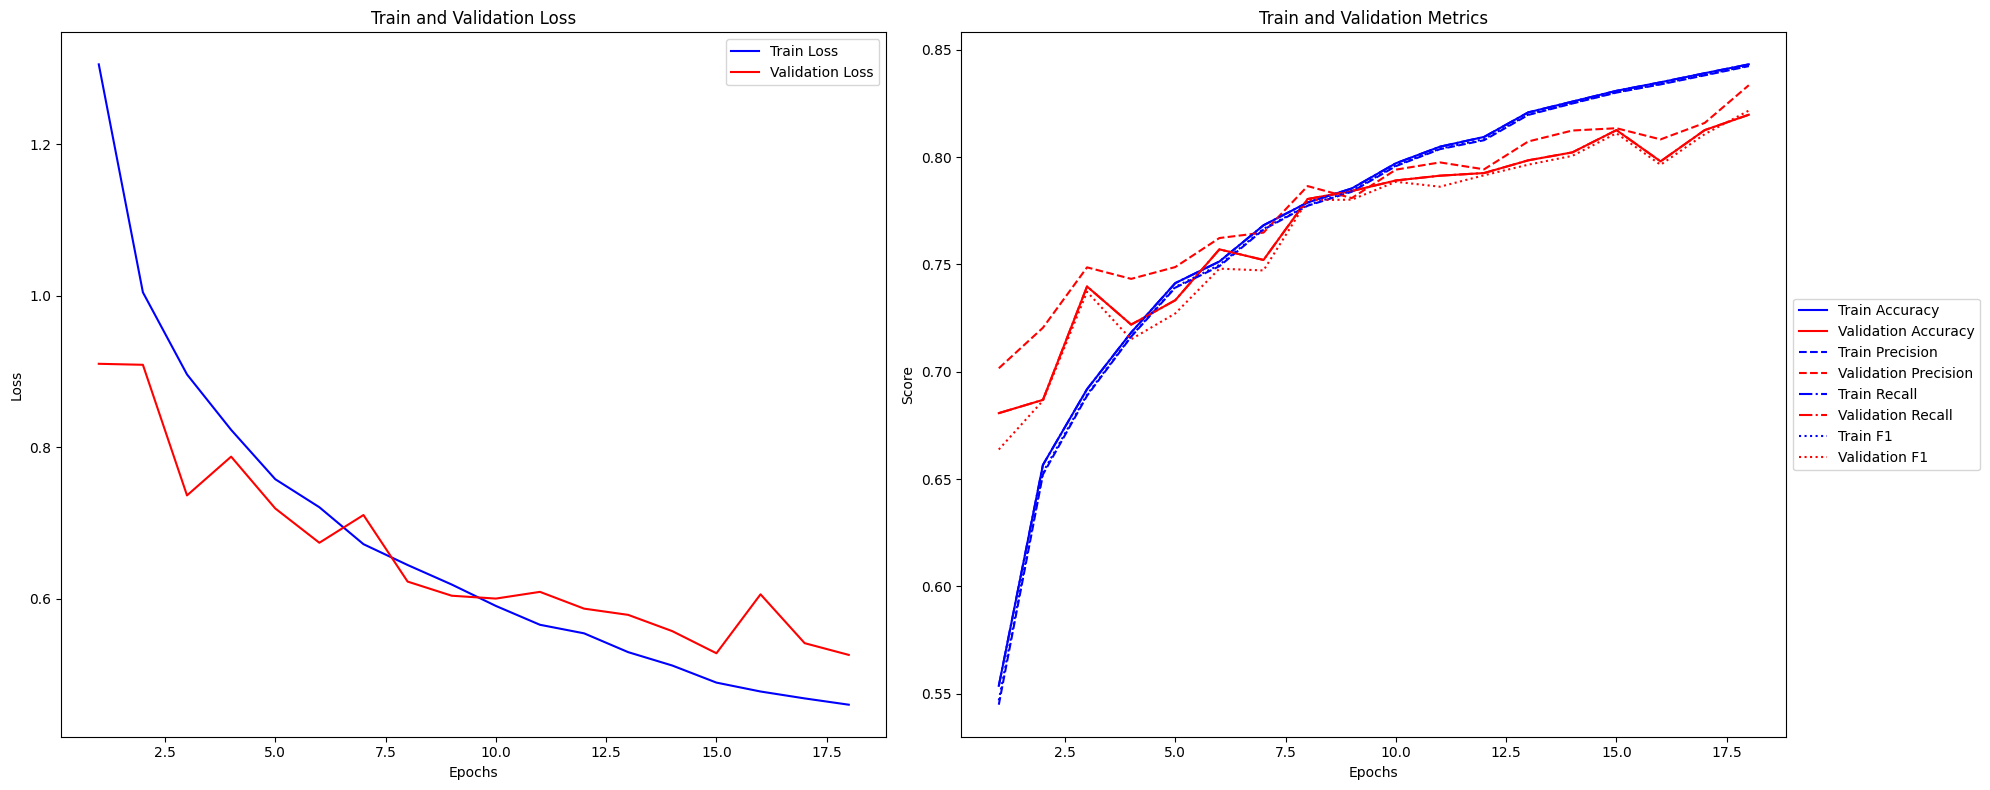

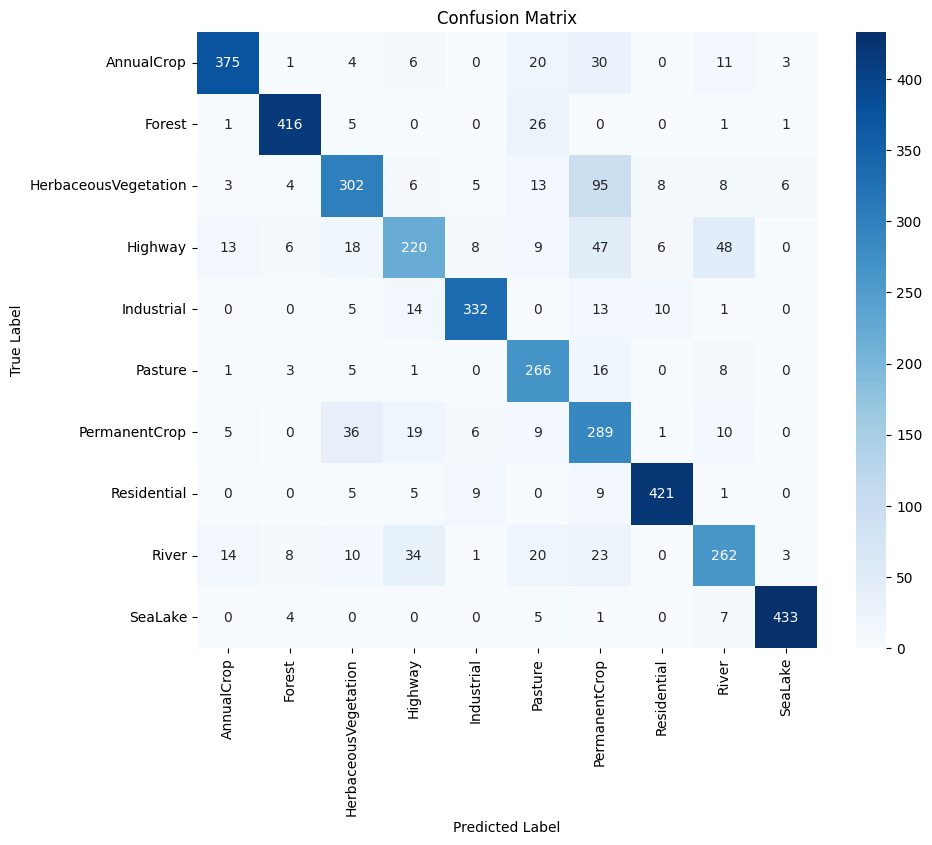

In [65]:
epochs = 40
model = cnn()

trainer = Trainer(
    model=model,
    dataloader=data_loaders,
    epochs=epochs,
    learning_rate=1e-4,
    best_model_filename='./best_model.pth',
    best_model_path=f"./Sentinel-2_Land_Cover_Dataset",
)

trainer.fit()
history = trainer.evaluate(testing=True)

print(f'Test loss: {history["loss"]} accuracy: {history["accuracy"]} precision: {history["precision"]} recall: {history["recall"]} f1: {history["f1"]}')

trainer.plot_metrics()
trainer.plot_confusion_matrix(history['confusion_matrix'], class_names)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             448
       BatchNorm2d-2           [-1, 16, 64, 64]              32
              ReLU-3           [-1, 16, 64, 64]               0
         MaxPool2d-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,640
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
         MaxPool2d-8           [-1, 32, 16, 16]               0
 AdaptiveAvgPool2d-9           [-1, 32, 16, 16]               0
          Flatten-10                 [-1, 8192]               0
           Linear-11                  [-1, 256]       2,097,408
          Dropout-12                  [-1, 256]               0
           Linear-13                   [-1, 10]           2,570
Total params: 2,105,162
Trainable param

Train Epoch 1/40: 100%|██████████| 788/788 [00:42<00:00, 18.63batch/s, loss=1.83]


Epoch 1 - Train Loss: 1.8184 - Train Accuracy: 0.5181 - Train F1: 0.5146 - Train Precision: 0.5124 - Train Recall: 0.5181


Val Epoch 1/40: 100%|██████████| 64/64 [00:06<00:00,  9.90batch/s, loss=1.14] 


Epoch 1 - Val Loss: 1.1157 - Val Accuracy: 0.5795 - Val F1: 0.5591 - Val Precision: 0.6582 - Val Recall: 0.5795
Validation loss improved from inf to 1.1157.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model.pth


Train Epoch 2/40: 100%|██████████| 788/788 [00:44<00:00, 17.57batch/s, loss=1.04]


Epoch 2 - Train Loss: 1.0423 - Train Accuracy: 0.6445 - Train F1: 0.6417 - Train Precision: 0.6406 - Train Recall: 0.6445


Val Epoch 1/40: 100%|██████████| 64/64 [00:05<00:00, 12.02batch/s, loss=0.861]


Epoch 1 - Val Loss: 0.8313 - Val Accuracy: 0.6896 - Val F1: 0.6859 - Val Precision: 0.7119 - Val Recall: 0.6896
Validation loss improved from 1.1157 to 0.8313.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model.pth


Train Epoch 3/40: 100%|██████████| 788/788 [00:44<00:00, 17.89batch/s, loss=0.95] 


Epoch 3 - Train Loss: 0.9496 - Train Accuracy: 0.6714 - Train F1: 0.6688 - Train Precision: 0.6677 - Train Recall: 0.6714


Val Epoch 1/40: 100%|██████████| 64/64 [00:05<00:00, 11.72batch/s, loss=0.831]


Epoch 1 - Val Loss: 0.8169 - Val Accuracy: 0.7240 - Val F1: 0.7116 - Val Precision: 0.7317 - Val Recall: 0.7240
Validation loss improved from 0.8313 to 0.8169.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model.pth


Train Epoch 4/40: 100%|██████████| 788/788 [00:45<00:00, 17.18batch/s, loss=0.821]


Epoch 4 - Train Loss: 0.8218 - Train Accuracy: 0.7166 - Train F1: 0.7144 - Train Precision: 0.7137 - Train Recall: 0.7166


Val Epoch 1/40: 100%|██████████| 64/64 [00:06<00:00,  9.69batch/s, loss=0.695]


Epoch 1 - Val Loss: 0.6933 - Val Accuracy: 0.7612 - Val F1: 0.7594 - Val Precision: 0.7709 - Val Recall: 0.7612
Validation loss improved from 0.8169 to 0.6933.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model.pth


Train Epoch 5/40: 100%|██████████| 788/788 [00:43<00:00, 17.97batch/s, loss=0.745]


Epoch 5 - Train Loss: 0.7461 - Train Accuracy: 0.7434 - Train F1: 0.7416 - Train Precision: 0.7409 - Train Recall: 0.7434


Val Epoch 1/40: 100%|██████████| 64/64 [00:06<00:00, 10.52batch/s, loss=0.686]


Epoch 1 - Val Loss: 0.6663 - Val Accuracy: 0.7600 - Val F1: 0.7533 - Val Precision: 0.7778 - Val Recall: 0.7600
Validation loss improved from 0.6933 to 0.6663.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model.pth


Train Epoch 6/40: 100%|██████████| 788/788 [00:43<00:00, 18.05batch/s, loss=0.675]


Epoch 6 - Train Loss: 0.6755 - Train Accuracy: 0.7693 - Train F1: 0.7680 - Train Precision: 0.7676 - Train Recall: 0.7693


Val Epoch 1/40: 100%|██████████| 64/64 [00:05<00:00, 11.10batch/s, loss=0.732]


Epoch 1 - Val Loss: 0.7409 - Val Accuracy: 0.7521 - Val F1: 0.7518 - Val Precision: 0.7701 - Val Recall: 0.7521
Validation loss did not improve from 0.6663 to 0.7409.
Early stop counter: 1/3


Train Epoch 7/40: 100%|██████████| 788/788 [00:43<00:00, 18.13batch/s, loss=0.654]


Epoch 7 - Train Loss: 0.6541 - Train Accuracy: 0.7744 - Train F1: 0.7730 - Train Precision: 0.7724 - Train Recall: 0.7744


Val Epoch 1/40: 100%|██████████| 64/64 [00:06<00:00, 10.31batch/s, loss=0.646]


Epoch 1 - Val Loss: 0.6330 - Val Accuracy: 0.7738 - Val F1: 0.7686 - Val Precision: 0.7929 - Val Recall: 0.7738
Validation loss improved from 0.6663 to 0.6330.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model.pth


Train Epoch 8/40: 100%|██████████| 788/788 [00:43<00:00, 18.24batch/s, loss=0.589]


Epoch 8 - Train Loss: 0.5887 - Train Accuracy: 0.7996 - Train F1: 0.7983 - Train Precision: 0.7979 - Train Recall: 0.7996


Val Epoch 1/40: 100%|██████████| 64/64 [00:06<00:00, 10.61batch/s, loss=0.601]


Epoch 1 - Val Loss: 0.5799 - Val Accuracy: 0.7980 - Val F1: 0.7938 - Val Precision: 0.8055 - Val Recall: 0.7980
Validation loss improved from 0.6330 to 0.5799.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model.pth


Train Epoch 9/40: 100%|██████████| 788/788 [00:43<00:00, 18.08batch/s, loss=0.542]


Epoch 9 - Train Loss: 0.5429 - Train Accuracy: 0.8163 - Train F1: 0.8154 - Train Precision: 0.8151 - Train Recall: 0.8163


Val Epoch 1/40: 100%|██████████| 64/64 [00:06<00:00, 10.42batch/s, loss=1.02] 


Epoch 1 - Val Loss: 0.9755 - Val Accuracy: 0.6612 - Val F1: 0.6425 - Val Precision: 0.7135 - Val Recall: 0.6612
Validation loss did not improve from 0.5799 to 0.9755.
Early stop counter: 1/3


Train Epoch 10/40: 100%|██████████| 788/788 [00:44<00:00, 17.52batch/s, loss=0.518]


Epoch 10 - Train Loss: 0.5177 - Train Accuracy: 0.8243 - Train F1: 0.8234 - Train Precision: 0.8230 - Train Recall: 0.8243


Val Epoch 1/40: 100%|██████████| 64/64 [00:05<00:00, 10.98batch/s, loss=0.615]


Epoch 1 - Val Loss: 0.5904 - Val Accuracy: 0.7933 - Val F1: 0.7943 - Val Precision: 0.8053 - Val Recall: 0.7933
Validation loss did not improve from 0.5799 to 0.5904.
Early stop counter: 2/3


Train Epoch 11/40: 100%|██████████| 788/788 [00:44<00:00, 17.51batch/s, loss=0.486]


Epoch 11 - Train Loss: 0.4865 - Train Accuracy: 0.8344 - Train F1: 0.8336 - Train Precision: 0.8333 - Train Recall: 0.8344


Val Epoch 1/40: 100%|██████████| 64/64 [00:05<00:00, 10.69batch/s, loss=0.652]


Epoch 1 - Val Loss: 0.6282 - Val Accuracy: 0.7938 - Val F1: 0.7930 - Val Precision: 0.8039 - Val Recall: 0.7938
Validation loss did not improve from 0.5799 to 0.6282.
Early stop counter: 3/3
Early stopping triggered at epoch 11.


Test Epoch 1/40: 100%|██████████| 64/64 [00:06<00:00, 10.20batch/s, loss=0.643]


Test loss: 0.621653042784601 accuracy: 0.7962962962962963 precision: 0.8064468587032384 recall: 0.7962962962962963 f1: 0.79615118892627


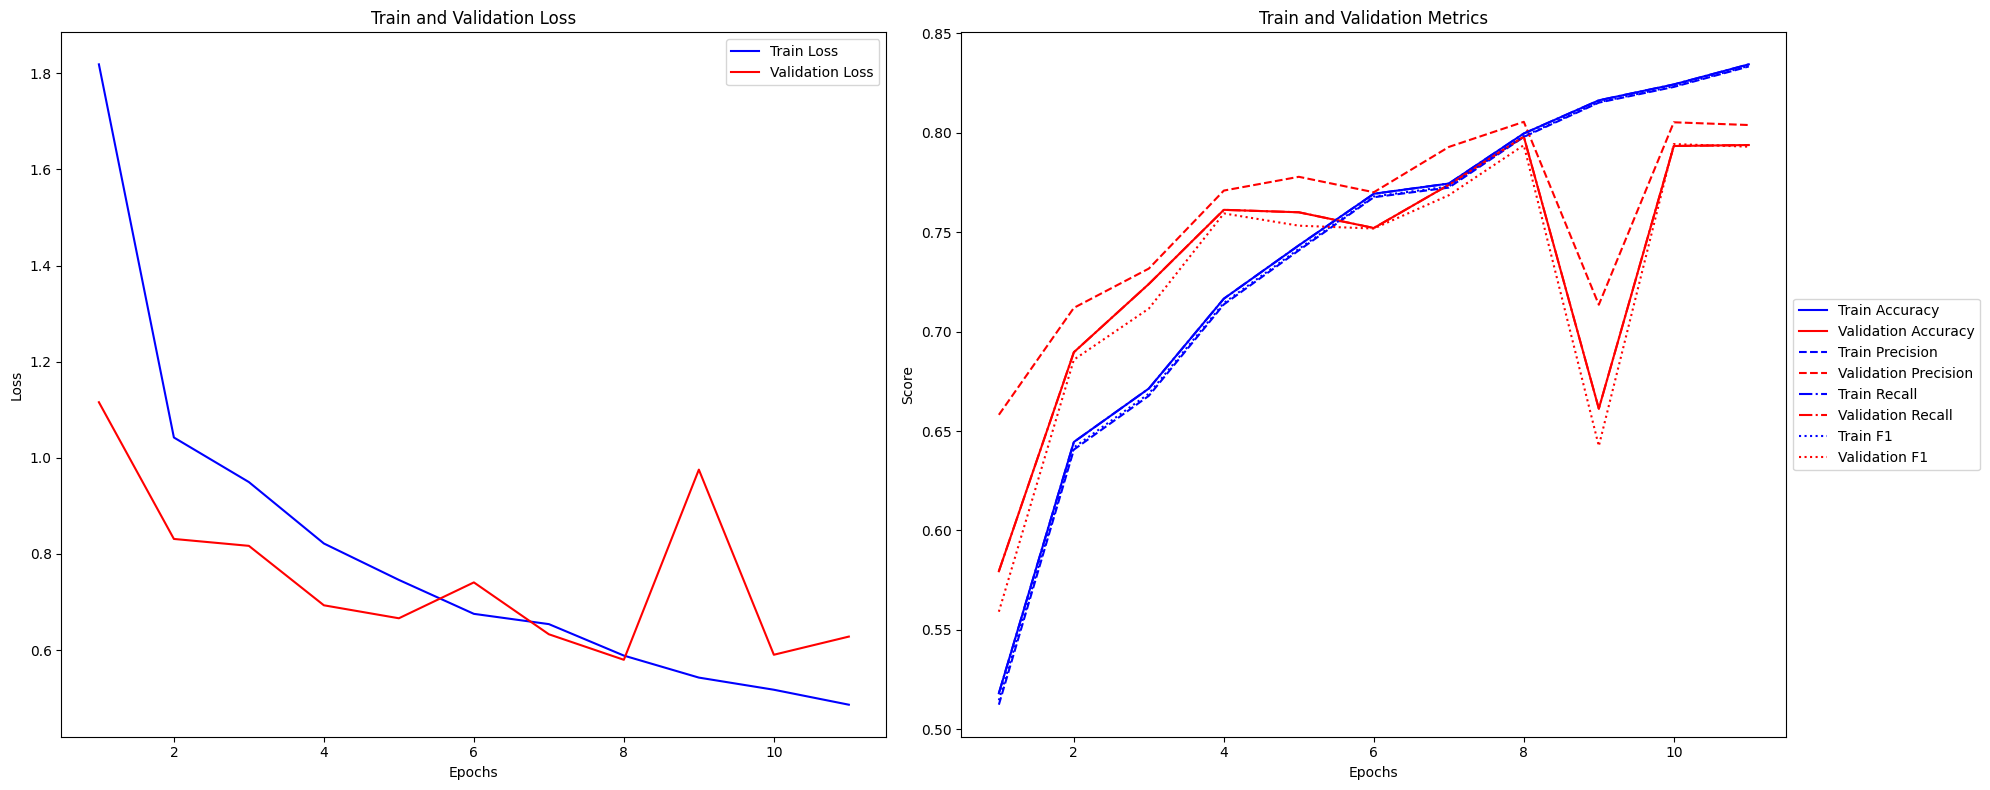

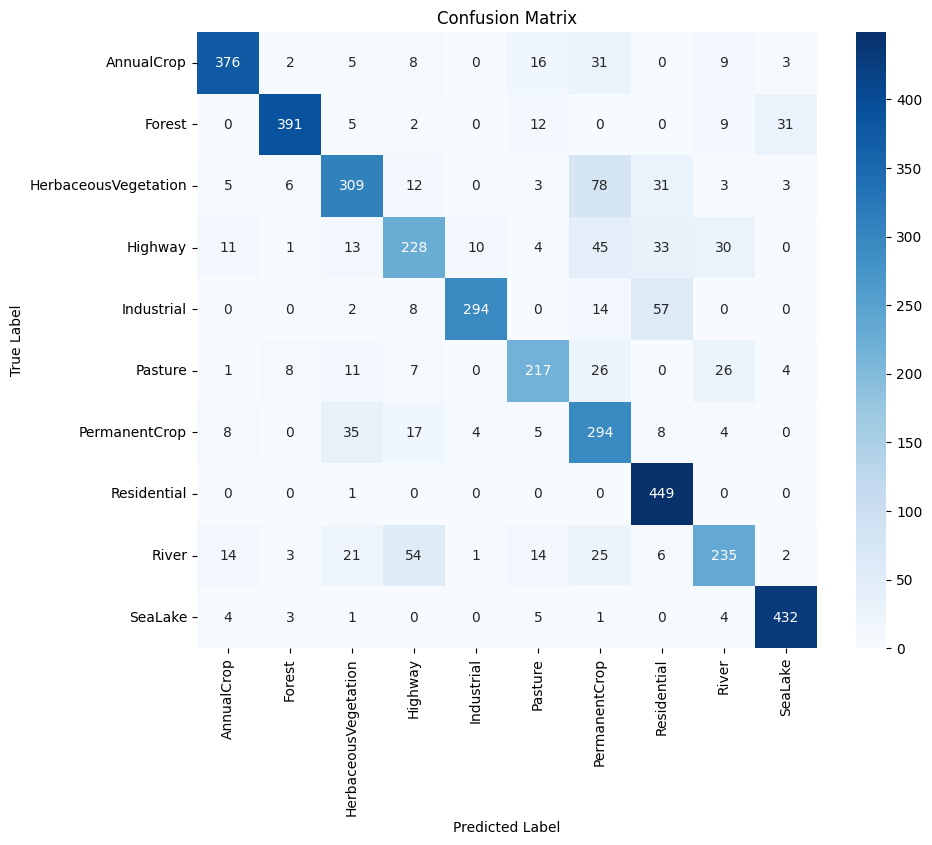

In [66]:
epochs = 40

model = cnn()
summary(model, (3, 64, 64))

trainer = Trainer(
    model=model,
    dataloader=data_loaders,
    epochs=epochs,
    learning_rate=1e-3,
    best_model_filename='./best_model.pth',
    best_model_path=f"./Sentinel-2_Land_Cover_Dataset",
)

trainer.fit()
history = trainer.evaluate(testing=True)

print(f'Test loss: {history["loss"]} accuracy: {history["accuracy"]} precision: {history["precision"]} recall: {history["recall"]} f1: {history["f1"]}')

trainer.plot_metrics()
trainer.plot_confusion_matrix(history['confusion_matrix'], class_names)

In [67]:
epochs = 40

model = cnn()
summary(model, (3, 64, 64))

trainer = Trainer(
    model=model,
    dataloader=data_loaders,
    epochs=epochs,
    learning_rate=1e-4,
    best_model_filename='./best_model.pth',
    best_model_path=f"./Sentinel-2_Land_Cover_Dataset",
)

trainer.fit()
history = trainer.evaluate(testing=True)

print(f'Test loss: {history["loss"]} accuracy: {history["accuracy"]} precision: {history["precision"]} recall: {history["recall"]} f1: {history["f1"]}')

trainer.plot_metrics()
trainer.plot_confusion_matrix(history['confusion_matrix'], class_names)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             448
       BatchNorm2d-2           [-1, 16, 64, 64]              32
              ReLU-3           [-1, 16, 64, 64]               0
         MaxPool2d-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,640
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
         MaxPool2d-8           [-1, 32, 16, 16]               0
 AdaptiveAvgPool2d-9           [-1, 32, 16, 16]               0
          Flatten-10                 [-1, 8192]               0
           Linear-11                  [-1, 256]       2,097,408
          Dropout-12                  [-1, 256]               0
           Linear-13                   [-1, 10]           2,570
Total params: 2,105,162
Trainable param

Train Epoch 1/40:  27%|██▋       | 215/788 [00:12<00:32, 17.68batch/s, loss=1.63]


KeyboardInterrupt: 